In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

plt.style.use("bmh")

# Introduction

## Background

Taylor Swift has been on music industry for more than 10 years; I've started listening to her song since I was in high school - roughly 8 years ago. Time flies, people change, and so do her songs. Her songs shifted from country to pop, and electropop on her Reputation album.

## Research Questions

Considering the various genres, do Taylor Swift's songs also contain various topics?

# Data Preparation

The song lyrics are scraped from [lyrics.com](http://lyrics.com); we use 119 Taylor Swift's song lyrics.

In [3]:
df_song = pd.read_csv("dataset/lyrics/taylor-swift.csv")
df_song = df_song.drop_duplicates(subset='title',keep='first')
df_song = df_song.loc[(df_song['artist'] == 'Taylor Swift')].copy()

In [4]:
def clean_line(series):
    series = series.replace('\n',' ').replace('\r','').replace('\t','')
    return series

cols = ['lyrics','info','credits']
for col in cols:
    df_song[col] = df_song[col].apply(clean_line)

In [5]:
df_song['year'] = df_song['info'].apply(lambda x: x.strip().split(':')[1].split(' ')[1] if ':' in x else None)
df_song['view'] = df_song['info'].apply(lambda x: x.strip().split(':')[1].split(' ')[3].strip().replace('Views','') if ':' in x else x.replace('Views','').replace(' ',''))

In [6]:
from collections import Counter

wc = {}

for idx, row in df_song.iterrows():
    wc[row['title']] = Counter(row['lyrics'].lower().split())

In [7]:
_l = []
for key in wc.keys():
    _l.append(len(wc[key].items()))
    
df_song['unique_word'] = _l

# Analysis

## Initial Exploration

Before 2013, Taylor Swift has more than 15 songs per release year. There is only one song in 2013 and 2015. Her earliest release year has the shortest range of unique words count per song. *Seems like she's getting more creative on her career growth?*

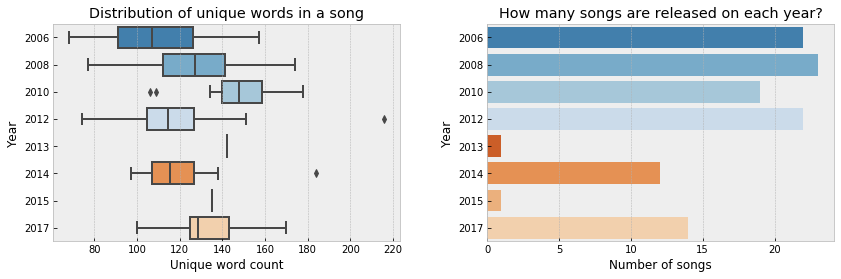

In [8]:
f, ax = plt.subplots(figsize=(14,4), ncols=2)
plt.subplots_adjust(wspace=.25)

sns.boxplot(
    data=df_song.sort_values(by='year'),
    y='year',
    x='unique_word',
    orient='h',
    palette='tab20c',
    ax=ax[0]
)

ax[0].set_title("Distribution of unique words in a song")
ax[0].set_xlabel("Unique word count")
ax[0].set_ylabel("Year")

_df = df_song.groupby('year').agg({'title':pd.Series.nunique}).reset_index()

sns.barplot(
    data=_df,
    y=_df['year'],
    x=_df['title'],
    orient='h',
    palette='tab20c',
    ax=ax[1]
)

ax[1].set_title("How many songs are released on each year?")
ax[1].set_xlabel("Number of songs")
ax[1].set_ylabel("Year")
plt.show();

In [36]:
df_song.loc[(df_song['year'].isin(['2013','2015'])),
           ['title','artist','year','unique_word']]

,title,artist,year,unique_word
14,New Romantics,Taylor Swift,2015,135
15,Sweeter Than Fiction,Taylor Swift,2013,142


Let's see common words used on one of her earliest and recent song: Fifteen (2008) and Look What You Made Me Do (2017).

Fifteen does have more unique words, and the words seem represent certain plot - see the *deep breath*, *when*, *fifteen*, *friends*, and the other words. Whereas on Look What You Made Me Do, it totally shows only a few words which are used repetitively.

Does it mean she make simpler songs recently? To verify our observation, let's check one more recent song: Gorgeous (2017). While it has more unique words than Look What You Made Me Do, we can't infer any story from the word clouds - *it's all about saying someone's face is gorgeous*.

In [10]:
from wordcloud import WordCloud, STOPWORDS 

def generate_wordcloud(text): # optionally add: stopwords=STOPWORDS and change the arg below
    wordcloud = WordCloud(relative_scaling = 1.0,
                          background_color = 'white',
                          random_state = 101,
                          width = 1200,
                          height = 600,
                          stopwords = {'to', 'of','and','the','but','as'} # set or space-separated string
                          ).generate(text)
    f, ax = plt.subplots(figsize=(12,6))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

Fifteen


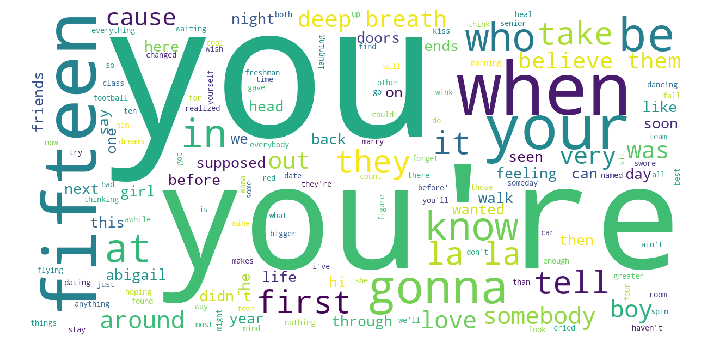

Look What You Made Me Do


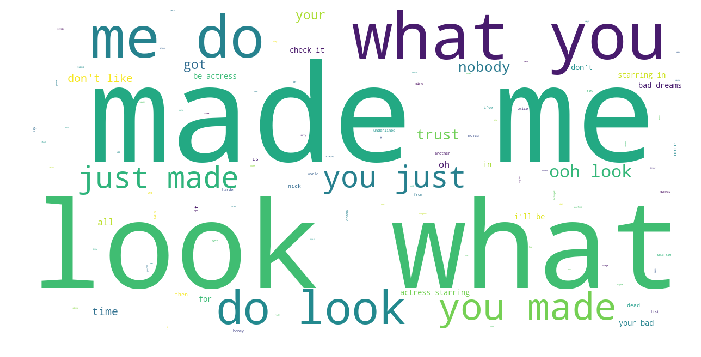

Gorgeous


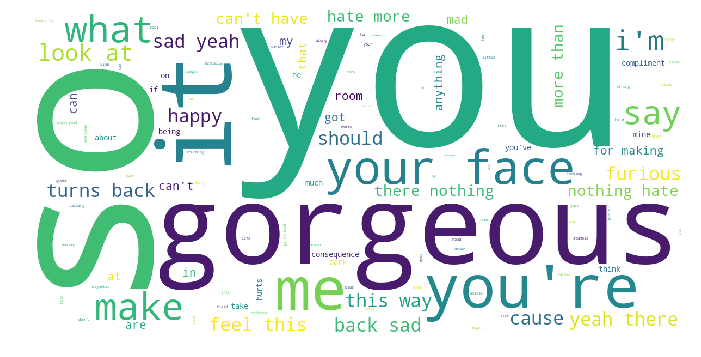

In [39]:
# create sample wordcloud for several songs
print(df_song['title'][0])
generate_wordcloud(df_song['lyrics'][0].lower())

print(df_song['title'][154])
generate_wordcloud(df_song['lyrics'][154].lower())

print(df_song['title'][156])
generate_wordcloud(df_song['lyrics'][156].lower())

Nah, we don't want to observe each song's word cloud and compare it one by one.. How about using more sophisticated method?

## Text Preprocessing

Here, we tokenize each words from song lyrics, remove the stop words and lemmatize the words. We use TF-IDF to determine importancy of each term - we use unigram and bigrams. There are much more less common words (rare) compared to the more common ones. The more common words are dominated by verbs (know, like, love, look).

In [12]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

from string import punctuation
from collections import Counter
import sys, re

In [13]:
from spacy.lang.en import English

nlp = English()
nlp.Defaults.stop_words.update(stop)

In [14]:
def tokenizer(text):
    return [token.lemma_.lower() for token in nlp(text) if not token.is_stop and not token.is_punct]

In [15]:
df_song['token'] = df_song['lyrics'].str.lower().map(tokenizer)

In [16]:
# store lyrics with cleaned tokens
_lyrics = []

for ix, row in df_song.iterrows():
    _txt = ''
    for word in row['token']:
        if word == ' ':
            continue
        else:
            _txt += word + ' '
    _lyrics.append(_txt)
    
df_song['lyrics_clean'] = _lyrics

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf_vec = TfidfVectorizer(min_df=10, max_features=10000, tokenizer=tokenizer, ngram_range=(1, 2))
vz = tfidf_vec.fit_transform(df_song['lyrics_clean'])

In [18]:
tfidf = dict(zip(tfidf_vec.get_feature_names(), tfidf_vec.idf_))
tfidf = pd.DataFrame(columns=['idf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['idf']

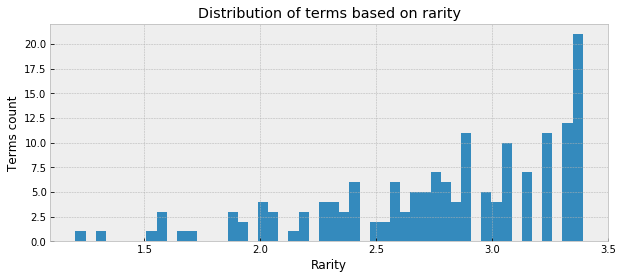

In [19]:
tfidf.idf.hist(bins=50, figsize=(10,4))
plt.xlabel("Rarity")
plt.ylabel("Terms count")
plt.title("Distribution of terms based on rarity")
plt.show()

In [20]:
print("More common terms:")
print(tfidf.sort_values(by=['idf'], ascending=True).head(10).index.values)

print("\n=========================\n")
print("Less common terms:")
print(tfidf.sort_values(by=['idf'], ascending=False).head(10).index.values)

More common terms:
['know' 'like' 'love' 'time' 'think' 'oh' 'come' 'look' 'tell' 'right']


Less common terms:
['high' 'mistake' 'wild' 'grind' 'fake' 'hey' 'let know' 'listen' 'sound'
 'someday']


## Dimensionality Reduction

After using TF-IDF, we have sparse metrics containing document-term matrix, in which its dimension equals to number of unique words. Oh no, we face the curse of dimensionality! But no worries, we could reduce its dimension so that it could be processed and visualized more easily.

In [21]:
from sklearn.decomposition import TruncatedSVD


svd = TruncatedSVD(n_components=50, random_state=101)
svd_tfidf = svd.fit_transform(vz)

In [22]:
# get number of unique tokens
_t = []

for ix, row in df_song.iterrows():
    for t in row['token']:
        if t not in _t:
            _t.append(t)
            
print("Number of unique tokens: {:,}".format((len(_t))))

Number of unique tokens: 1,508


In [23]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, verbose=1, random_state=101)
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 119 samples in 0.000s...
[t-SNE] Computed neighbors for 119 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 119 / 119
[t-SNE] Mean sigma: 0.451755
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.803425
[t-SNE] Error after 1000 iterations: 0.531938


In [24]:
print("Dimension after SVD: ", svd_tfidf.shape)
print("Dimension after t-SNE: ", tsne_tfidf.shape)

Dimension after SVD:  (119, 50)
Dimension after t-SNE:  (119, 2)


## Clustering

use umap

In [25]:
import umap

reducer = umap.UMAP(n_components=2,
                    n_neighbors=10,
                    random_state=101)
embedding = reducer.fit_transform(tsne_tfidf)

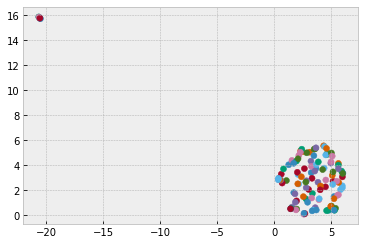

In [26]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in range(0,df_song.year.nunique())]);

In [27]:
# from sklearn.cluster import DBSCAN
import hdbscan

# clf = DBSCAN()
clf = hdbscan.HDBSCAN()
clf.fit(tsne_tfidf)
print('Number of clusters: {}'.format(len(np.unique(clf.labels_))))

df_song['cluster'] = clf.labels_

Number of clusters: 3


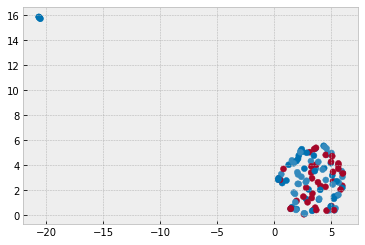

In [28]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in df_song['cluster'].unique()]);

## Topic Modelling

In [29]:
import lda
import logging
logging.getLogger("lda").setLevel(logging.WARNING)

cvectorizer = CountVectorizer(min_df=4, max_features=10000, tokenizer=tokenizer, ngram_range=(1,2))
cvz = cvectorizer.fit_transform(df_song['lyrics_clean'])

n_topics = 3
n_iter = 2000
lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter, random_state=101)
X_topics = lda_model.fit_transform(cvz)

In [30]:
n_top_words = 10
topic_summaries = []

topic_word = lda_model.topic_word_  # get the topic words
vocab = cvectorizer.get_feature_names()
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: love come know like time oh wish right tell baby
Topic 1: oh oh oh know girl ah place look car think home
Topic 2: know like think look want oh stay eye night shake


In [31]:
tsne_lda = tsne_model.fit_transform(X_topics)


doc_topic = lda_model.doc_topic_
lda_keys = []
for i, txt in enumerate(df_song['lyrics_clean']):
    lda_keys += [doc_topic[i].argmax()]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 119 samples in 0.000s...
[t-SNE] Computed neighbors for 119 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 119 / 119
[t-SNE] Mean sigma: 0.185557
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.281097
[t-SNE] Error after 750 iterations: 0.110982


In [32]:
lda_df = pd.DataFrame(tsne_lda, columns=['x','y'])
lda_df['lyrics'] = df_song['lyrics']
lda_df['year'] = df_song['year']
lda_df['title'] = df_song['title']

lda_df['topic'] = lda_keys
lda_df['topic'] = lda_df['topic'].map(int)

lda_df['token'] = df_song['token']
lda_df['len_docs'] = df_song['token'].map(len)

In [33]:
def prepareLDAData(lda_model, lda_df, cvectorizer):
    data = {
        'vocab': vocab,
        'doc_topic_dists': lda_model.doc_topic_,
        'doc_lengths': list(lda_df['len_docs']),
        'term_frequency':cvectorizer.vocabulary_,
        'topic_term_dists': lda_model.components_
    } 
    return data

In [34]:
import pyLDAvis
pyLDAvis.enable_notebook()

lda_data = prepareLDAData(lda_model=lda_model, lda_df=lda_df, cvectorizer=cvectorizer)
prepared_data = pyLDAvis.prepare(**lda_data)
pyLDAvis.display(prepared_data)

# Results and Discussions

*describe what you find and how it can be improved*

# References



[1] Morris, C. 2017. An Exercise in Language Compression: Are pop lyrics getting more repetitive? Accessed [here](https://pudding.cool/2017/05/song-repetition/).

[2] Besbes, A. 2017. How to mine newsfeed data and extract interactive insights in Python. Accessed [here](https://ahmedbesbes.com/how-to-mine-newsfeed-data-and-extract-interactive-insights-in-python.html).